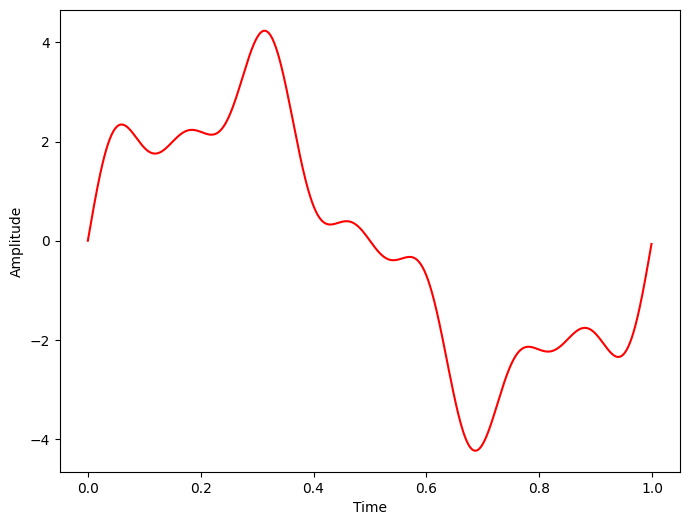

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# sampling rate
sr = 1000
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += np.sin(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.xlabel("Time")
plt.ylabel('Amplitude')

plt.show()

In [61]:
np.arange(5)

array([0, 1, 2, 3, 4])

/Users/hunkim/Github/earth_science/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/hunkim/Github/earth_science/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


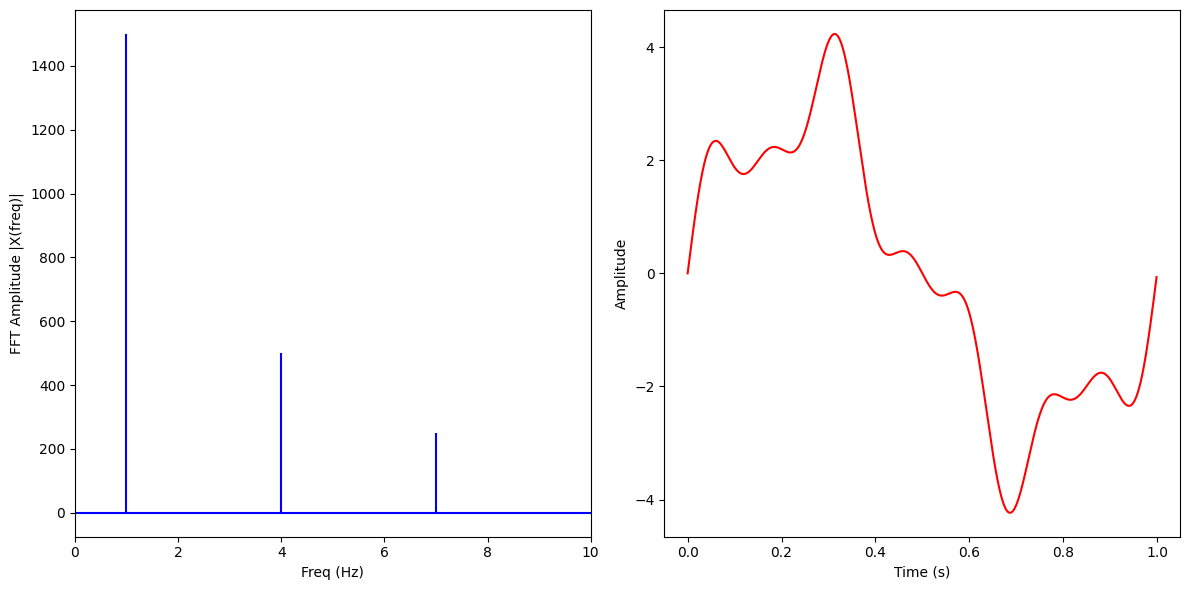

In [62]:
from numpy.fft import fft, ifft

X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 


plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

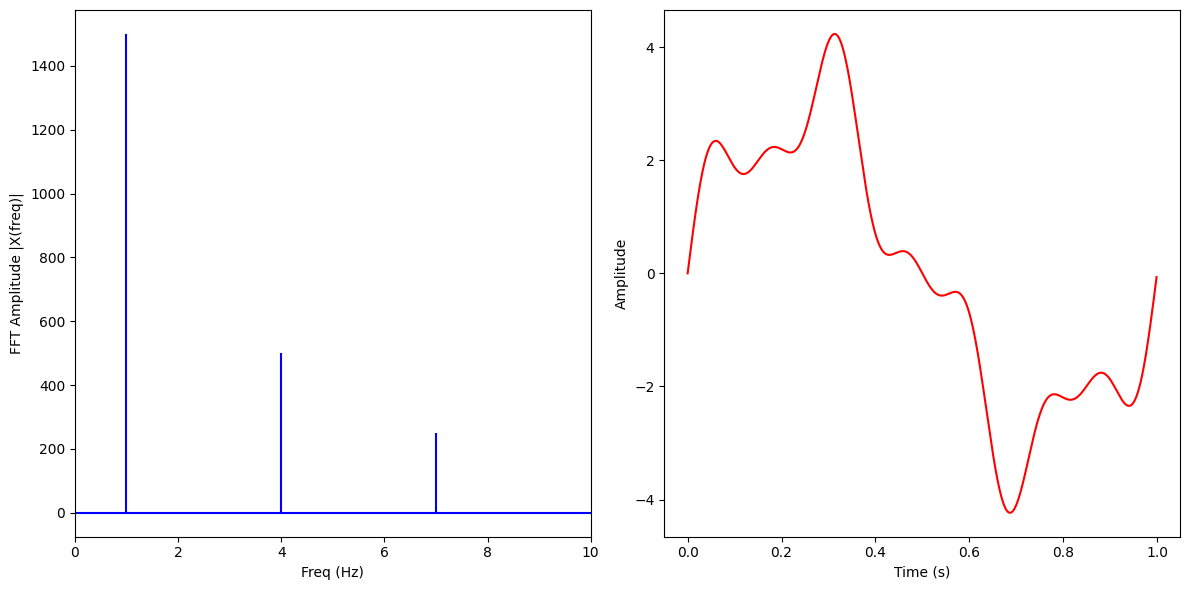

In [63]:
from scipy.fftpack import fft, ifft

X = fft(x)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

### FFT in action

https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html


In [64]:
import pandas as pd

# Using parse_dates=[1] will parse the 'Timestamp (Hour Ending)' column as dates, but
# since the timestamp has a "PST" string at the end, pandas may have trouble with the timezone,
# and it emits a warning (see notebook_cell_output_0 and notebook_cell_output_2).
# It will fall back to using dateutil parser, which parses the datetime string but may not handle PST timezone properly.

df = pd.read_csv(
    "california-930-data-export.csv",
    parse_dates=["Timestamp (Hour Ending)"]
)
df.rename(columns={'Timestamp (Hour Ending)': 'hour',
                   'Demand (MWh)': 'demand'},
          inplace=True)

# If you want to ensure timezone-aware datetimes, you need to supply 'date_parser' or handle timezones after reading:
# Example (optional, not required for current output, see instructions):
# df['hour'] = pd.to_datetime(df['hour'], utc=True, errors='coerce')

/var/folders/wy/50c5sv7n4wsfhhww_wwjz2tr0000gn/T/ipykernel_10732/854757861.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


In [65]:
df.head()

,Region Code,hour,demand,Demand Forecast (MWh),Net Generation (MWh),Total Interchange (MWh)
0,CAL,1/28/2026 12 a.m. PST,28196.0,27862,4043.0,-7764.0
1,CAL,1/28/2026 1 a.m. PST,26669.0,26384,3746.0,-8851.0
2,CAL,1/28/2026 2 a.m. PST,25715.0,25443,3640.0,-8633.0
3,CAL,1/28/2026 3 a.m. PST,24983.0,24631,3695.0,-8611.0
4,CAL,1/28/2026 4 a.m. PST,24660.0,24339,3631.0,-8225.0


/Users/hunkim/Github/earth_science/.venv/lib/python3.13/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


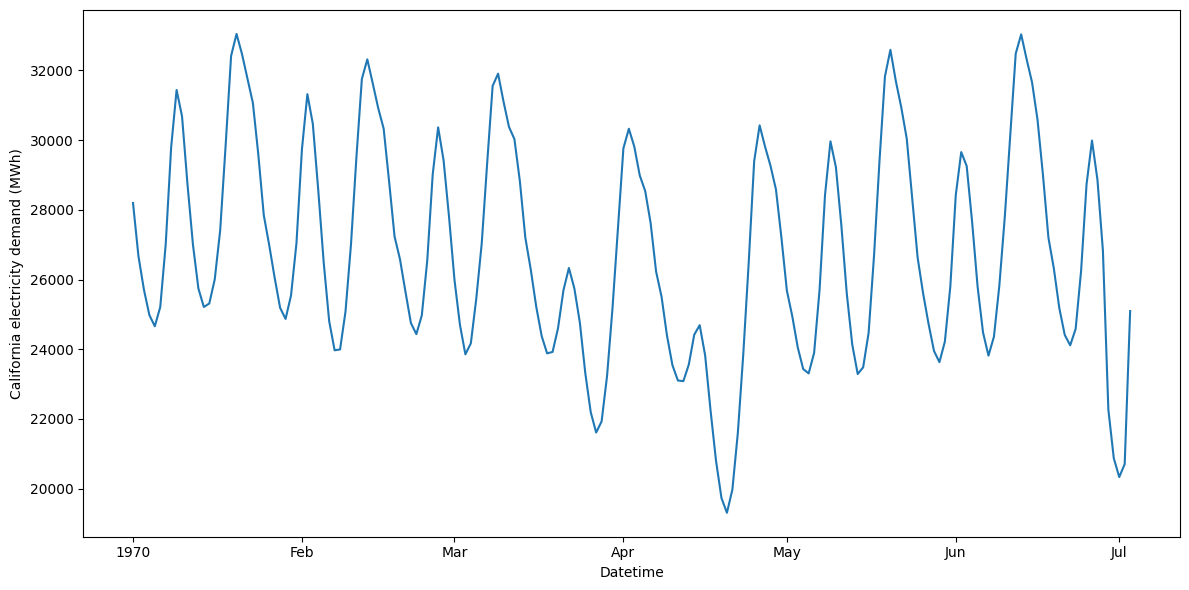

In [66]:
import matplotlib.dates as mdates

plt.figure(figsize = (12, 6))
plt.plot(df['hour'], df['demand'])
plt.xlabel('Datetime')
plt.ylabel('California electricity demand (MWh)')

ax = plt.gca()

# Use AutoDateLocator and AutoDateFormatter to make the ticks smart
locator = mdates.AutoDateLocator(minticks=6, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Optionally, you can still rotate if any labels overlap, but with concise formatting it's rarely needed
plt.tight_layout()
plt.show()

In [67]:
df["demand"]

0      28196.0
1      26669.0
2      25715.0
3      24983.0
4      24660.0
        ...   
188        NaN
189        NaN
190        NaN
191        NaN
192        NaN
Name: demand, Length: 193, dtype: float64

From the plotted time series, it is hard to tell there are some patterns behind the data. Let us transform the data into frequency domain and see if there is anything interesting.


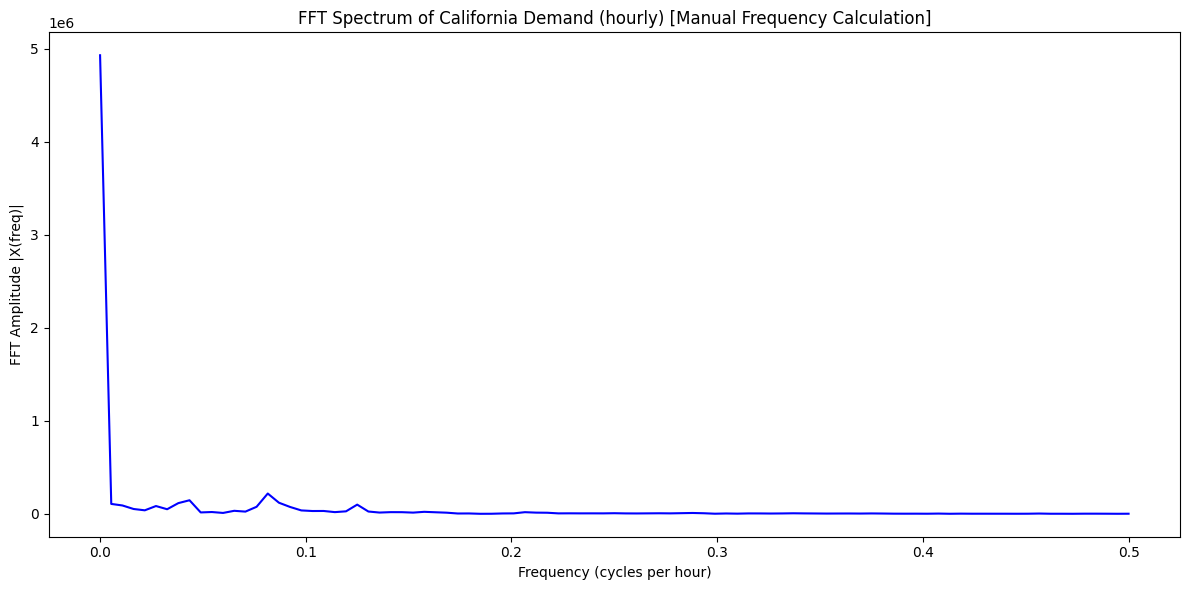

In [68]:
# Alternative way to calculate the FFT frequency bins by hand for clarity:

from scipy.fft import fft

# Remove NaN values as FFT cannot handle them
demand = df['demand'].dropna().to_numpy()

N = len(demand)
T = 1  # Sampling interval is 1 hour (delta t = 1 hour)

X = fft(demand)

# Instead of using fftfreq, calculate frequencies manually:
# The FFT corresponds to frequencies from 0 up to the Nyquist frequency (1/(2*T)).
# The frequency bin width is 1/(N*T), and there are N total frequencies:
freqs_manual = np.arange(N) / (N * T)

# Since the signal is real, take only the positive frequencies (first N//2+1 entries for even N).
# For odd N, np.fft.rfftfreq(N, T) gives you first (N+1)//2 frequencies:
n_positive = N // 2 + 1 if N % 2 == 0 else (N + 1) // 2
freqs_pos = freqs_manual[:n_positive]
X_pos = X[:n_positive]

plt.figure(figsize=(12, 6))
plt.plot(freqs_pos, np.abs(X_pos), 'b')
plt.xlabel('Frequency (cycles per hour)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT Spectrum of California Demand (hourly) [Manual Frequency Calculation]')
plt.tight_layout()
plt.show()

We see some clear peaks in the FFT amplitude figure, but it is hard to tell what are they in terms of frequency. Let us plot the results using hours and highlight some of the hours associated with the peaks.

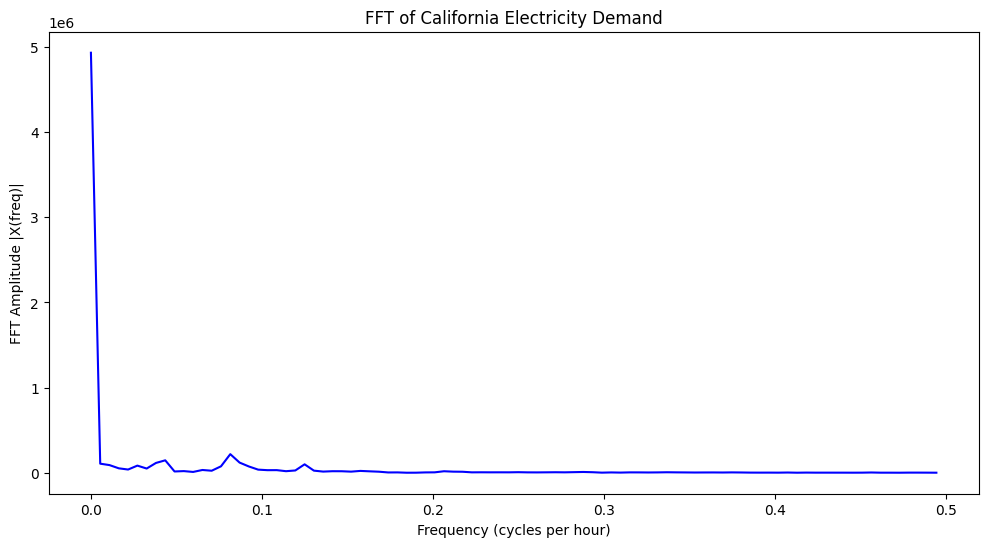

In [69]:
from scipy.fft import fft

# Remove NaN values as FFT cannot handle them
demand = df['demand'].dropna().to_numpy()

X = fft(demand)
N = len(X)

# Sampling interval is 1 hour
T = 1  # hour
# Frequency bins (cycles per hour)
freqs = np.arange(N) / (N * T)

# Get the one-sided spectrum
n_oneside = N // 2
f_oneside = freqs[:n_oneside]

plt.figure(figsize=(12, 6))
plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
plt.xlabel('Frequency (cycles per hour)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of California Electricity Demand')
plt.show()

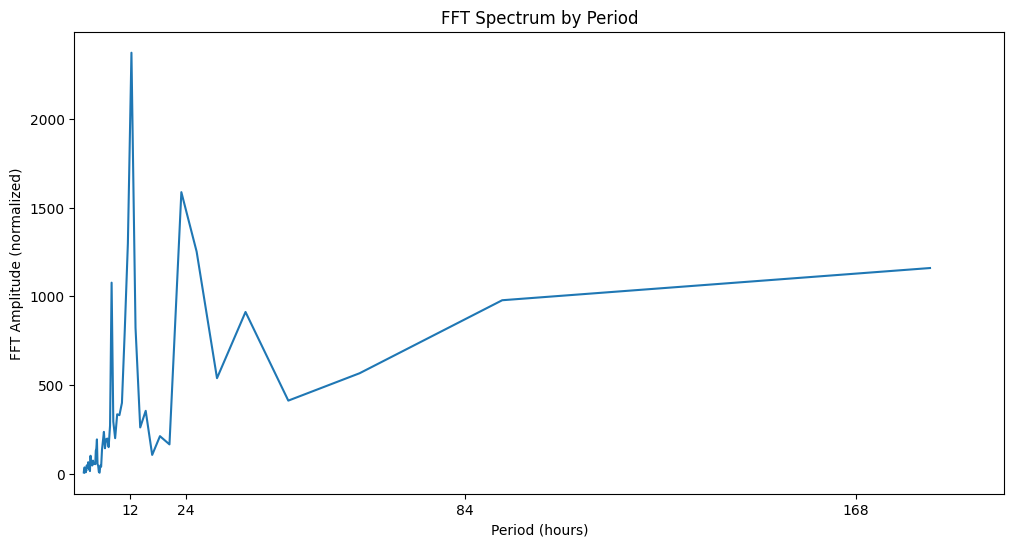

In [70]:
# Convert frequency to period (hours)
# Skip index 0 (DC component) to avoid division by zero
f_oneside_no_dc = f_oneside[1:]
X_oneside_no_dc = X[1:n_oneside]

period_hours = 1 / f_oneside_no_dc  # Simple inverse: period = 1/frequency

plt.figure(figsize=(12, 6))
plt.plot(period_hours, np.abs(X_oneside_no_dc) / n_oneside)
plt.xlabel('Period (hours)')
plt.ylabel('FFT Amplitude (normalized)')
plt.title('FFT Spectrum by Period')
plt.xlim(0, 200)
plt.xticks([12, 24, 84, 168])
plt.show()

  ### Practical Interpretation

  - Tall peak at 24h: Strong daily rhythm - people wake up, use electricity during the day, sleep at night
  - Peak at 168h: Weekly pattern - offices/factories run on weekdays, lower demand on weekends
  - Smaller peaks: Harmonics or subtler patterns in human behavior

  ### Note on Your Data

  You only have ~188 hours of data (about 8 days), so:
  - The 168h (weekly) peak may be weak or unreliable - you barely have one full week
  - For robust weekly pattern detection, you'd want several weeks of data
  - The 24h peak should be clear even with limited data

  The FFT essentially answers: "If I had to reconstruct this demand signal using only sine waves, which frequencies would I need most?"